In [19]:
#data analysis of the predictions
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
from statsmodels.regression.linear_model import OLS
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
import datetime
from sklearn.metrics import roc_auc_score
%matplotlib inline

In [27]:
alldata_processed =\
    pd.read_csv("data/annotations/alldata_processed_with_dev_residual.csv" )
alldata_processed['videoid'] = alldata_processed['videoid'].apply(lambda x: int(x))
alldata_processed['Event_Date'] = pd.to_datetime(alldata_processed['Event_Date'],format='%Y-%m-%d')

In [39]:
#RR AUCROC
df = alldata_processed.copy()

In [41]:
predictions = pd.read_csv("predictions/rr_SEMLS_dev_residual_predictions.csv",dtype={'videoid':int})[['videoid','side','SEMLS_dev_residual_pred']]
df = df.merge(right=predictions,on=['videoid','side'],how='left')
Xcols = ["mass_interpolated","mass_interpolated2","age_truncated2","age_truncated",
         "height_interpolated","height_interpolated2",
         'SEMLS_dev_residual_pred',"isPostSurgGaitVisit","const"]

X_train = df[df['dataset'] == 'train'][Xcols]
y_train = df[df['dataset'] == 'train']["SEMLS"]
X = df[Xcols]
y = df["SEMLS"]

lm = Logit(y_train,X_train).fit()

df['predicted_SEMLS_rr'] = lm.predict(X)

Optimization terminated successfully.
         Current function value: 0.414854
         Iterations 7


In [45]:
#RF AUCROC
predictions = pd.read_csv("predictions/rf_SEMLS_dev_residual_predictions.csv",dtype={'videoid':int})[['videoid','side','SEMLS_dev_residual_pred']]
df = df.drop('SEMLS_dev_residual_pred',axis=1)
df = df.merge(right=predictions,on=['videoid','side'],how='left')
Xcols = ["mass_interpolated","mass_interpolated2","age_truncated2","age_truncated",
         "height_interpolated","height_interpolated2",
         'SEMLS_dev_residual_pred',"isPostSurgGaitVisit","const"]

X_train = df[df['dataset'] == 'train'][Xcols]
y_train = df[df['dataset'] == 'train']["SEMLS"]
X = df[Xcols]
y = df["SEMLS"]

lm = Logit(y_train,X_train).fit()

df['predicted_SEMLS_rf'] = lm.predict(X)

Optimization terminated successfully.
         Current function value: 0.007205
         Iterations 15


In [46]:
#CNN AUCROC
predictions = pd.read_csv("predictions/cnn_SEMLS_dev_residual_predictions_best_epoch.csv",dtype={'videoid':int})[['videoid','side','SEMLS_dev_residual_pred_corrected']]
df = df.drop('SEMLS_dev_residual_pred',axis=1)
df = df.merge(right=predictions,on=['videoid','side'],how='left')

Xcols = ["mass_interpolated","mass_interpolated2","age_truncated2","age_truncated",
         "height_interpolated","height_interpolated2",
         'SEMLS_dev_residual_pred_corrected',"isPostSurgGaitVisit","const"]

X_train = df[df['dataset'] == 'train'][Xcols]
y_train = df[df['dataset'] == 'train']["SEMLS"]
X = df[Xcols]
y = df["SEMLS"]

lm = Logit(y_train,X_train).fit()

df['predicted_SEMLS_CNN'] = lm.predict(X)


Optimization terminated successfully.
         Current function value: 0.389973
         Iterations 7


In [61]:
#CNN AUCROC
Xcols = ["mass_interpolated","mass_interpolated2","age_truncated2","age_truncated",
         "height_interpolated","height_interpolated2",
         'GDI',"isPostSurgGaitVisit","const"]

X_train = df[df['dataset'] == 'train'][Xcols]
y_train = df[df['dataset'] == 'train']["SEMLS"]
X = df[Xcols]
y = df["SEMLS"]

lm = Logit(y_train,X_train).fit()

df['predicted_SEMLS_GDI'] = lm.predict(X)


Optimization terminated successfully.
         Current function value: 0.406605
         Iterations 7


In [47]:
from sklearn.metrics import roc_curve

In [62]:
fpr_cnn, tpr_cnn, _ = roc_curve(df[df['dataset'] == 'test']['SEMLS'],
          df[df['dataset'] == 'test']['predicted_SEMLS_CNN'])

fpr_rf, tpr_rf, _ = roc_curve(df[df['dataset'] == 'test']['SEMLS'],
          df[df['dataset'] == 'test']['predicted_SEMLS_rf'])

fpr_rr, tpr_rr, _ = roc_curve(df[df['dataset'] == 'test']['SEMLS'],
          df[df['dataset'] == 'test']['predicted_SEMLS_rr'])

fpr_gdi, tpr_gdi, _ = roc_curve(df[df['dataset'] == 'test']['SEMLS'],
          df[df['dataset'] == 'test']['predicted_SEMLS_GDI'])

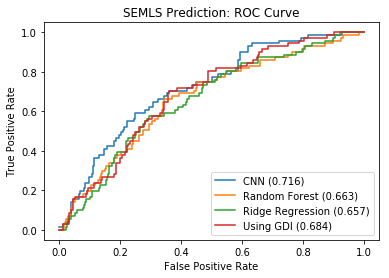

In [69]:
plt.plot(fpr_cnn,tpr_cnn,label="CNN (0.716)")
plt.plot(fpr_rf,tpr_rf,label="Random Forest (0.663)")
plt.plot(fpr_rr,tpr_rr,label="Ridge Regression (0.657)")
plt.plot(fpr_gdi,tpr_gdi,label="Using GDI (0.684)")
plt.legend(loc=4)
plt.title("SEMLS Prediction: ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig("figures/semls_performance.png",dpi=600)

In [68]:
print(roc_auc_score(df[df['dataset'] == 'test']['SEMLS'],
              df[df['dataset'] == 'test']['predicted_SEMLS_CNN']),"CNN: test ROC")

print(roc_auc_score(df[df['dataset'] == 'test']['SEMLS'],
              df[df['dataset'] == 'test']['predicted_SEMLS_rf']),"RF: test ROC")

print(roc_auc_score(df[df['dataset'] == 'test']['SEMLS'],
              df[df['dataset'] == 'test']['predicted_SEMLS_rr']),"RR: test ROC")

print(roc_auc_score(df[df['dataset'] == 'test']['SEMLS'],
              df[df['dataset'] == 'test']['predicted_SEMLS_GDI']),"Using GDI: test ROC")


(0.71631488648605512, 'CNN: test ROC')
(0.6631688145872402, 'RF: test ROC')
(0.65742329330088178, 'RR: test ROC')
(0.68395642979691174, 'Using GDI: test ROC')
